In [15]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
#from util.team_strength_team_stats import calculate_team_stats, calculate_chances_from_played_games, calculate_features_based_on_certain_matchweeks, generate_dataset, create_home_away_pairs
from util.team_strength_team_stats import *
from statsbombpy import sb
from statsbombpy.api_client import NoAuthWarning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score


%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nuanced Team Strength Model

### Legend:  
🔴- to do <br>
🟠- in progress <br>
🟢- done <br>


### Used Features to quantify Team Strength:
- 🟢 Possession
- 🟢 Shots on Goal/ 🔴 on Target
- 🟢 Goals 
- 🟢 Goals_conceded
- 🟢 X_Goals
- 🟢 Passes 
- 🟠 Duels


### Other Features used to predict Match Outcomes:
- 🔴 Last 5 matches


### Output Predictions
- 🟢 Label of Match Status for Home Team
- 🔴 Betting Odds for both Home and Away Team

### Trainings/Test Daten
<br>


### Prior Baseline (Aus Literatur Outcome Prediction Modelle anschauen)


# Event Types, etc.

In [5]:
# Load data
matches = load_matches(competition_id=9, season_id=27)

test_event = sb.events(match_id=3890259)
test_event.shape

print('------------distinct_types----------------')
print(test_event['type'].unique())
print('------------pass_outcome----------------')
print(test_event['pass_outcome'].unique())
print('------------pass_type-------------')
print(test_event['pass_type'].unique())
print('------------pass_height----------------')
print(test_event['pass_height'].unique())

------------distinct_types----------------
['Starting XI' 'Half Start' 'Pass' 'Pressure' 'Ball Receipt*' 'Carry'
 'Duel' 'Clearance' 'Ball Recovery' 'Interception' 'Dispossessed'
 'Miscontrol' 'Block' 'Foul Committed' 'Foul Won' 'Shot' 'Goal Keeper'
 'Shield' '50/50' 'Dribble' 'Dribbled Past' 'Injury Stoppage' 'Player Off'
 'Player On' 'Half End' 'Error' 'Substitution' 'Tactical Shift']
------------pass_outcome----------------
[nan 'Incomplete' 'Out' 'Unknown' 'Pass Offside']
------------pass_type-------------
[nan 'Kick Off' 'Throw-in' 'Recovery' 'Free Kick' 'Goal Kick' 'Corner'
 'Interception']
------------pass_height----------------
[nan 'Ground Pass' 'High Pass' 'Low Pass']


# Getting the informations out of the event dataframes

## Single Match ( First Game of Bundesliga Season 15/16)

In [6]:
team_stats = calculate_team_stats(event=test_event)
team_stats

,team,completed_passes,total_passes,pass_completion_percentage,Shots,duels,xG,Goals,Goals Conceded,Possession
0,Bayern Munich,711,797,89.209536,22,76,2.24,5.0,0.0,78.0
1,Hamburger SV,150,240,62.500000,5,76,0.08,0.0,5.0,22.0


## All Matches of Bundesliga Season 15/16
The following Code takes long to execute, since its pulling the data from the statsbomb API (therefore its written locally in a csv file)

In [7]:
'''
all_team_stats = []
for _, match in matches.iterrows(): 
   match_id = match['match_id'] 
   match_date = match['match_date']
   match_week = match['match_week']
   #print(f'Start gathering Information from Match_ID = {match_id}')
   match_stats = calculate_team_stats(sb.events(match_id=match_id))
   match_stats['match_id'] = match_id
   match_stats['match_date'] = match_date
   match_stats['match_week'] = match_week
   all_team_stats.append(match_stats)
#   match_day += 1

team_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')
team_stats.to_csv('./Data/team_strength_stats.csv')
'''

"\nall_team_stats = []\nfor _, match in matches.iterrows(): \n   match_id = match['match_id'] \n   match_date = match['match_date']\n   match_week = match['match_week']\n   #print(f'Start gathering Information from Match_ID = {match_id}')\n   match_stats = calculate_team_stats(sb.events(match_id=match_id))\n   match_stats['match_id'] = match_id\n   match_stats['match_date'] = match_date\n   match_stats['match_week'] = match_week\n   all_team_stats.append(match_stats)\n#   match_day += 1\n\nteam_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')\nteam_stats.to_csv('./Data/team_strength_stats.csv')\n"

## Now in the Dataframe Team_Stats is every Stat for every Team for every Match

In [8]:
team_stats = pd.read_csv('./Data/team_strength_stats.csv')
team_stats['match_date'] = pd.to_datetime(team_stats['match_date'])
team_stats.sort_values('match_date')


#For example get the average pass completion percentage
team_stats.groupby(['team'])['pass_completion_percentage'].mean().reset_index(name='avg_pass_completion_percentage').sort_values('avg_pass_completion_percentage', ascending=False).head(20)

,team,avg_pass_completion_percentage
2,Bayern Munich,86.538269
3,Borussia Dortmund,82.751210
17,Wolfsburg,81.192701
4,Borussia Mönchengladbach,79.465608
14,Schalke 04,78.534258
11,Hertha Berlin,77.500490
0,Augsburg,74.321272
7,FC Köln,73.537738
1,Bayer Leverkusen,72.752820
12,Hoffenheim,72.739057


In [9]:

chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, 35)), round_decimals=None)
home_team = 'Bayern Munich'
away_team = 'Borussia Dortmund'
# This function creates a single entry which contains the stats of the teams, based on certain matchweeks and assigns the actual game result
single_datapoint = calculate_features_based_on_certain_matchweeks(home_team=home_team, away_team=away_team, chances=chances, matches=matches)

single_datapoint

,home_team,home_avg_completed_passes,home_avg_total_passes,home_avg_pass_comp_pct,home_avg_shots,home_avg_duels,home_avg_goals,away_team,away_avg_completed_passes,away_avg_total_passes,away_avg_pass_comp_pct,away_avg_shots,away_avg_duels,away_avg_goals,match_week,actual_result
0,Bayern Munich,662.205882,760.647059,86.538269,18.294118,68.058824,2.294118,Borussia Dortmund,565.911765,675.941176,82.75121,15.411765,72.5,2.352941,8,Home_Victory


In [10]:
train_dataset = generate_dataset(team_stats=team_stats, matches=matches, amount_of_weeks_to_simulate=150)


In [21]:
X = train_dataset.drop(columns=['actual_result','match_week'])  # All columns except the target
y = train_dataset['actual_result']  # Just the target column

# Initial split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

categorical_features = ['home_team', 'away_team']
numerical_features = X_train.columns.difference(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])


# 1. Create a base pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', None)  # Placeholder for the actual model
])


def safe_f1_weighted(y_true, y_pred):
    labels_in_data = list(set(y_true) | set(y_pred))
    if len(labels_in_data) < 2:
        return 0.0
    return f1_score(y_true, y_pred, average='weighted', labels=labels_in_data)

f1_weight_scorer = make_scorer(safe_f1_weighted)

print("Class distribution in y_train:", pd.Series(y_train).value_counts^^())


# 2. Define the parameter grid that includes different models
param_grid = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [100, 400],
        'model__max_depth': [None, 10]
    },
    {
        'model': [LogisticRegression(max_iter=1000)],
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l2']
    },
    {
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.1, 0.5]
    },
    {
        'model': [SVC(probability=True)],
        'model__C': [0.1, 1],
        'model__kernel': ['linear', 'rbf']
    }
]

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring=f1_weight_scorer,
    error_score='raise' ,
    verbose=1,
    n_jobs=-1,
    refit=True  # Will refit the best model on full training data
)

# 4. Fit once - will test all models and parameters
grid.fit(X_train, y_train)

# 5. Results
print(f"Best model: {grid.best_estimator_.named_steps['model']}")
print(f"Best params: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.3f}")

# To use the best model:
best_model = grid.best_estimator_
predictions = best_model.predict(X_test)

Class distribution in y_train: actual_result
Home_Victory    491
Home_Defeat     335
Draw            254
Name: count, dtype: int64
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best model: GradientBoostingClassifier(learning_rate=0.5)
Best params: {'model': GradientBoostingClassifier(), 'model__learning_rate': 0.5, 'model__n_estimators': 100}
Best CV score: 0.743


In [22]:
probabilities_array = best_model.predict_proba(X_test)
probabilities_array.shape  #'Draw', 'Home_Defeat', 'Home_Victory'

x_probabilities = pd.DataFrame(
    data=probabilities_array,
    columns=['Draw', 'Home_Defeat', 'Home_Victory'],
    index=X_test.index
)
x_probabilities = x_probabilities.add_prefix('predicted_')

y_test_proba = pd.get_dummies(y_test, dtype='float64')
y_test_proba = y_test_proba.add_prefix('actual_')

prediction_and_outcome = pd.merge(x_probabilities, y_test_proba, left_index=True, right_index=True)
prediction_and_outcome = pd.merge(prediction_and_outcome, train_dataset['match_week'], left_index=True, right_index=True)

prediction_and_outcome['brier_score'] = (
    (prediction_and_outcome['predicted_Draw'] - prediction_and_outcome['actual_Draw']) ** 2 +
    (prediction_and_outcome['predicted_Home_Defeat'] - prediction_and_outcome['actual_Home_Defeat']) ** 2 +
    (prediction_and_outcome['predicted_Home_Victory'] - prediction_and_outcome['actual_Home_Victory']) ** 2
)


brier_scores_week = prediction_and_outcome.groupby('match_week').agg(brier_score=('brier_score', 'mean'))


print(f'Brier Score: {brier_scores_week['brier_score'].mean()}')

Brier Score: 0.3290279162741392


# Test with the Real Bundesliga 15/16 Matchdata

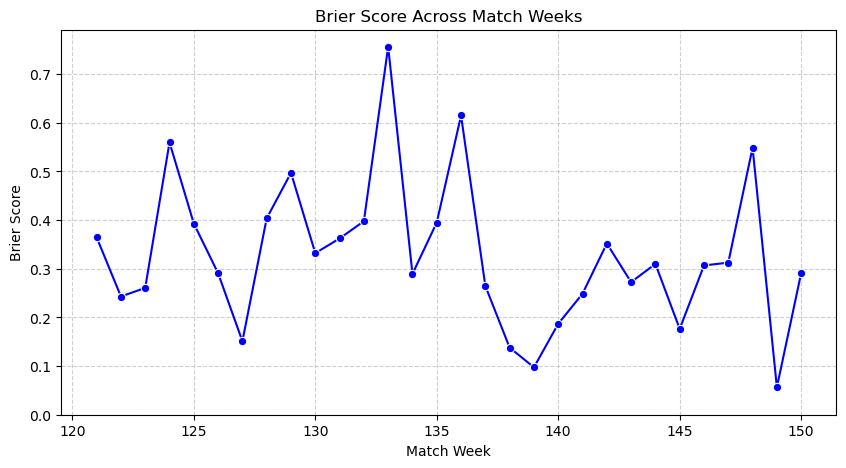

In [23]:
# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=brier_scores_week, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [25]:
all_features = []
for i in range(1,matches['match_week'].max()+1):
    team_pairings = matches[matches['match_week'] == i]
    # Cheating the stats data for first match_week because we cannot predict a game, when no game before is played
    if i == 1:
        real_chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, matches['match_week'].max()+1)), round_decimals=None)
        for _, match in team_pairings.iterrows():
            features = calculate_features_based_on_certain_matchweeks(home_team=match['home_team'],away_team=match['away_team'], chances= real_chances, matches=matches)
            all_features.append(features)
    else:
        real_chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, i)), round_decimals=None)
        for _, match in team_pairings.iterrows():
            features = calculate_features_based_on_certain_matchweeks(home_team=match['home_team'],away_team=match['away_team'], chances= real_chances, matches=matches)
            all_features.append(features)

final_features = pd.concat(all_features, ignore_index=True)
final_features

,home_team,home_avg_completed_passes,home_avg_total_passes,home_avg_pass_comp_pct,home_avg_shots,home_avg_duels,home_avg_goals,away_team,away_avg_completed_passes,away_avg_total_passes,away_avg_pass_comp_pct,away_avg_shots,away_avg_duels,away_avg_goals,match_week,actual_result
0,Bayern Munich,662.205882,760.647059,86.538269,18.294118,68.058824,2.294118,Hamburger SV,331.470588,456.882353,71.539875,11.029412,94.676471,1.088235,1,Home_Victory
1,Augsburg,328.441176,436.205882,74.321272,12.911765,81.441176,1.176471,Hertha Berlin,389.794118,498.794118,77.500490,9.705882,79.441176,1.205882,1,Home_Defeat
2,Bayer Leverkusen,352.852941,480.264706,72.752820,14.117647,94.029412,1.500000,Hoffenheim,332.647059,447.470588,72.739057,11.235294,77.852941,1.147059,1,Home_Victory
3,Werder Bremen,276.823529,398.882353,68.834760,13.264706,96.852941,1.441176,Schalke 04,390.411765,493.911765,78.534258,14.294118,80.000000,1.382353,1,Home_Defeat
4,Darmstadt 98,154.941176,280.852941,54.770078,10.205882,92.852941,1.117647,Hannover 96,318.911765,436.294118,72.323609,11.147059,89.852941,0.882353,1,Draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Darmstadt 98,153.303030,279.484848,54.487037,10.242424,93.333333,1.151515,Borussia Mönchengladbach,465.181818,580.848485,79.234630,13.181818,79.121212,1.878788,34,Home_Defeat
302,Borussia Dortmund,556.121212,666.818182,82.501464,15.484848,72.878788,2.363636,FC Köln,335.484848,448.878788,73.916674,12.060606,79.181818,1.090909,34,Draw
303,Bayer Leverkusen,357.030303,484.363636,73.069002,14.242424,93.939394,1.454545,Ingolstadt,253.030303,392.787879,63.742880,12.242424,105.151515,0.939394,34,Home_Victory
304,Augsburg,326.939394,434.878788,74.187068,12.939394,81.484848,1.181818,Hamburger SV,331.242424,457.484848,71.357012,10.939394,95.121212,1.030303,34,Home_Defeat


In [27]:
X_real = final_features.drop(columns=['actual_result','match_week'])  # All columns except the target
y_real = final_features['actual_result']  # Just the target column


print(f"Real features: {X_real.shape}, Real labels: {y_real.shape}")

predictions_real = best_model.predict(X_real)



Real features: (306, 14), Real labels: (306,)


              precision    recall  f1-score   support

        Draw       0.71      0.65      0.68        71
 Home_Defeat       0.83      0.79      0.81       100
Home_Victory       0.79      0.85      0.82       135

    accuracy                           0.78       306
   macro avg       0.78      0.76      0.77       306
weighted avg       0.78      0.78      0.78       306



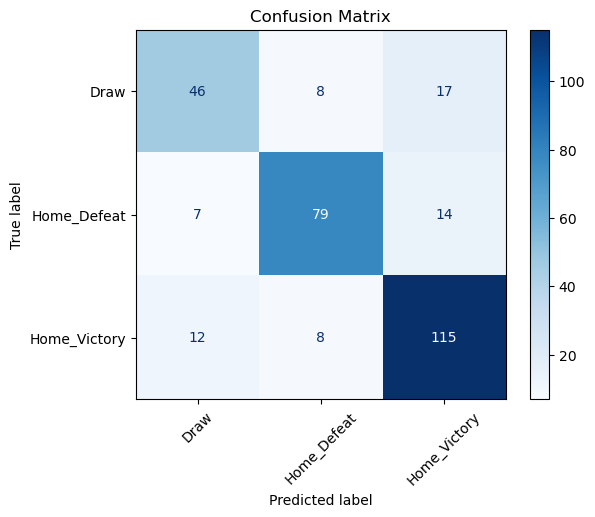

In [28]:
print(
    classification_report(
        y_real,          # True labels (strings)
        predictions_real,          # Predicted labels (strings)
        target_names=['Draw', 'Home_Defeat', 'Home_Victory']  # Optional: ensures consistent order
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_real,
    predictions_real,
    display_labels=['Draw', 'Home_Defeat', 'Home_Victory'],
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.show()

In [29]:
probabilities_array_real = best_model.predict_proba(X_real)
probabilities_array_real.shape  #'Draw', 'Home_Defeat', 'Home_Victory'

x_probabilities_real = pd.DataFrame(
    data=probabilities_array_real,
    columns=['Draw', 'Home_Defeat', 'Home_Victory'],
    index=X_real.index
)
x_probabilities_real = x_probabilities_real.add_prefix('predicted_')

y_real_proba = pd.get_dummies(y_real, dtype='float64')
y_real_proba = y_real_proba.add_prefix('actual_')

prediction_and_outcome_real = pd.merge(x_probabilities_real, y_real_proba, left_index=True, right_index=True)
prediction_and_outcome_real = pd.merge(prediction_and_outcome_real, final_features['match_week'], left_index=True, right_index=True)

prediction_and_outcome_real['brier_score'] = (
    (prediction_and_outcome_real['predicted_Draw'] - prediction_and_outcome_real['actual_Draw']) ** 2 +
    (prediction_and_outcome_real['predicted_Home_Defeat'] - prediction_and_outcome_real['actual_Home_Defeat']) ** 2 +
    (prediction_and_outcome_real['predicted_Home_Victory'] - prediction_and_outcome_real['actual_Home_Victory']) ** 2
)


brier_scores_week_real = prediction_and_outcome_real.groupby('match_week').agg(brier_score=('brier_score', 'mean'))


print(f'Brier Score: {brier_scores_week_real['brier_score'].mean()}')

Brier Score: 0.31837230289270124


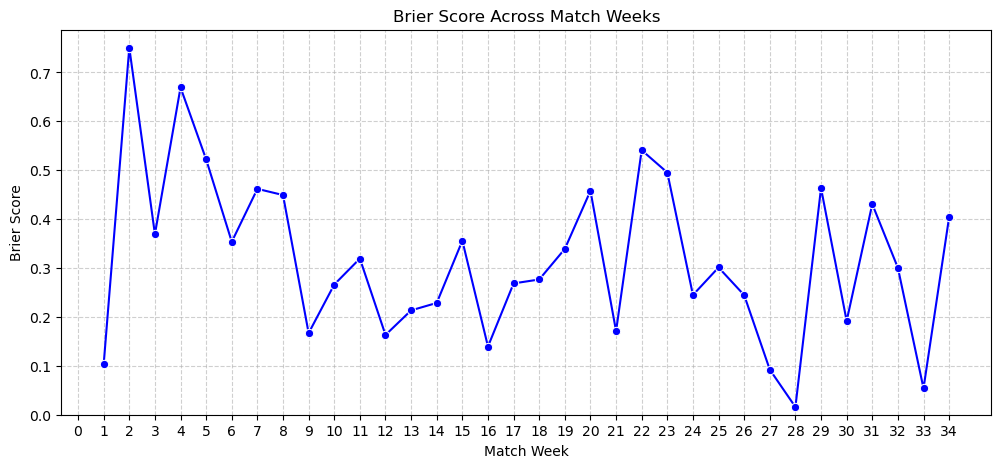

In [30]:
# Create the plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=brier_scores_week_real, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(35))  # range(35) generates numbers 0 through 34


# Show the plot
plt.show()

# Gathering some infomation about Teams

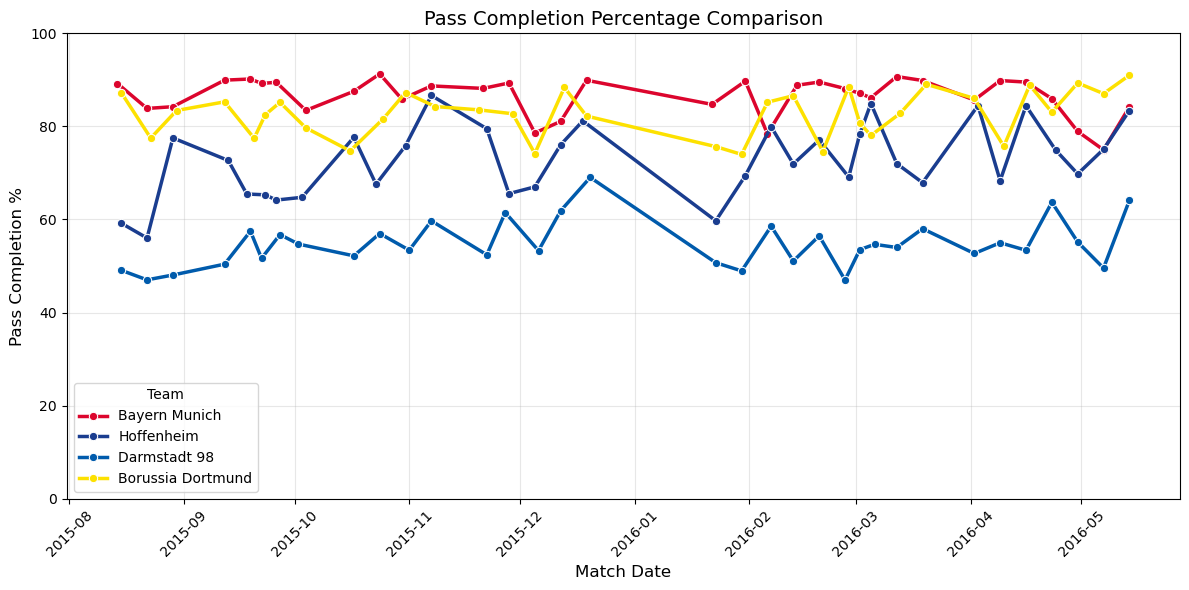

In [41]:
pass_completion_rates = team_stats[['team', 'match_date', 'pass_completion_percentage']]

teams_to_plot = ['Bayern Munich', 'Borussia Dortmund', 'Darmstadt 98', 'Hoffenheim']
multi_team_data = pass_completion_rates[pass_completion_rates['team'].isin(teams_to_plot)]


custom_colors = {
    'Bayern Munich': '#DC052D',        # Red
    'Borussia Dortmund': '#FDE100',    # Yellow
    'Darmstadt 98': '#005BAC',         # Blue
    'Hoffenheim': '#1A3D8F'            # Dark Blue
}
# Create plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=multi_team_data,
             x='match_date',
             y='pass_completion_percentage',
             hue='team',
             marker='o',
             palette= custom_colors,
             linewidth=2.5)

plt.title('Pass Completion Percentage Comparison', fontsize=14)
plt.xlabel('Match Date', fontsize=12)
plt.ylabel('Pass Completion %', fontsize=12)
plt.legend(title='Team')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()